In [1]:
import sys
import pathlib
import os
from skmap.catalog import s3_setup, DataCatalog
from skmap.loader import TiledDataLoader
from skmap.overlay import SpaceOverlay, SpaceTimeOverlay
from skmap.misc import find_files, GoogleSheet, ttprint
import random
import pandas as pd
import time
import skmap_bindings as sb
import numpy as np
import geopandas as gpd
import json
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from model_fit import read_features, parameter_fine_tuning, evaluate_model, weighted_ccc, separate_data, calc_metrics
import joblib
from density_estimation import bw_cvl, inverse_density_weight

folder_path = '/home/xuemeng/work_xuemeng/soc/SoilHealthDataCube'

# Prepare

In [2]:
# model
model = joblib.load(f'{folder_path}/data/010_model_fine.tuned.joblib')
model.n_jobs=90

# covariates
covs = read_features(f'{folder_path}/data/008_cov_rscfi.txt')
print(f'{len(covs)} covariates')

# data
train = pd.read_parquet(f'{folder_path}/data/006_data_train.pq')
test = pd.read_parquet(f'{folder_path}/data/004_data_test.pq')

# set up
cv = KFold(n_splits=5) 
prop = 'ocd'
space = 'log1p'
tgt = f'{prop}_log1p'

train[tgt] = np.log1p(train[prop])
test[tgt] = np.log1p(test[prop])

67 covariates


# Inverse Sampling-Intensity Weights

1. **Select the Best Grid Width**  
   Use criteria developed by [Cronie and Van Lieshout (2018)](https://doi.org/10.1093/biomet/asy001) to identify the optimal grid width.

2. **Calculate Sampling Intensity and Corresponding Weights**  
   Compute the sampling intensity and derive the corresponding weights for each point using the grid defined in the previous step, following the method described by [Deutsch (1989)](https://doi.org/10.1016/0098-3004(89)90043-5).


In [3]:
from shapely.geometry import Point

# conver training data to gpd
points = [Point(xy) for xy in zip(train['lon'], train['lat'])]
gdf = gpd.GeoDataFrame(train, geometry=points, crs="EPSG:4326")
gdf = gdf.to_crs("EPSG:3035")

In [3]:
# Run CvL bandwidth selection
ttprint('start bandwidth selection')
results = bw_cvl(gdf, ns=10) #, srange=(0.01, 0.2)
selected_bandwidth = results["optimal_bandwidth"]
ttprint(f'finish bandwidth selection: {selected_bandwidth}')

[18:13:51] start bandwidth selection
[18:49:20] finish bandwidth selection: 2693.9440124727125


In [14]:
# Run CvL bandwidth selection
candidate_width = list(np.arange(2000, 25000, 4000))
ttprint('start bandwidth selection')
results = bw_cvl(gdf, sigma = candidate_width)
selected_bandwidth = results["optimal_bandwidth"]
ttprint(f'finish bandwidth selection: {selected_bandwidth}')

[10:38:56] start bandwidth selection
[10:59:37] finish bandwidth selection: 2000


In [15]:
candidate_width = list(np.arange(1000, 6000, 1000))
ttprint('start bandwidth selection')
results = bw_cvl(gdf, sigma = candidate_width)
selected_bandwidth = results["optimal_bandwidth"]
ttprint(f'finish bandwidth selection: {selected_bandwidth}')

[11:38:23] start bandwidth selection
[11:55:19] finish bandwidth selection: 3000


In [13]:
ttprint('start calculating weights')
bandwidth = 3000 # Bandwidth in meters
coordinates = np.array([(point.x, point.y) for point in gdf.geometry])

from scipy.stats import gaussian_kde
kde = gaussian_kde(coordinates.T, bw_method=bandwidth) # / np.ptp(coordinates, axis=0).max()
density = kde(coordinates.T)

# from sklearn.neighbors import KernelDensity
# coordinates = np.array([(point.x, point.y) for point in gdf.geometry])
# kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(coordinates)
# log_density = kde.score_samples(coordinates)  # Get log-density estimates
# density = np.exp(log_density)  


weights = 1 / density
gdf['weights'] = weights
gdf['density'] = density

ttprint('finish calculating weights')

[14:06:09] start calculating weights
[14:06:26] finish calculating weights


In [14]:
gdf = gdf.drop(columns = ['geometry'])
# gdff.loc[gdff['weights']==0,'weights'] = 1
gdf.to_parquet(f'{folder_path}/data/015_data.with.weights_train.pq')

<Axes: >

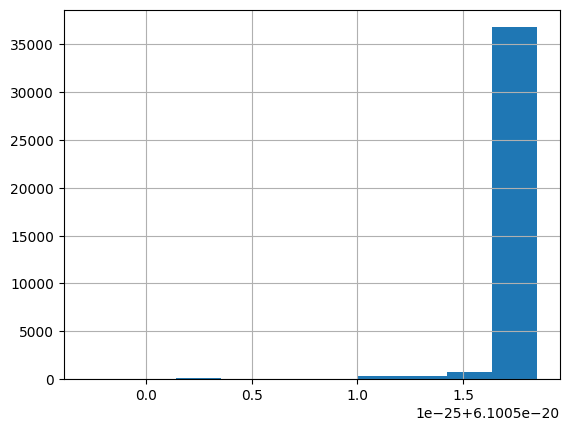

In [15]:
gdf['density'].hist()

# Inverse Sampling-Intensity Weighted Cross-Validation
   
Apply the inverse sampling-intensity weighted cross-validation approach developed by [De Bruin (2022)](https://www.sciencedirect.com/science/article/pii/S1574954122001145?via%3Dihub#s0030).

In [16]:
train = pd.read_parquet(f'{folder_path}/data/015_data.with.weights_train.pq')

ttprint('start spatial CV')
y_scv = cross_val_predict(model, train[covs], train[tgt], cv=cv, n_jobs=60)
ttprint('finish spatial CV')

train['isiw_cv'] = y_scv

[14:07:06] start spatial CV
[14:07:27] finish spatial CV


# Leave one Year Out Cross-Validation (LOYCV)

In [17]:
from sklearn.model_selection import LeaveOneGroupOut

groups = train['time']
logo = LeaveOneGroupOut()
ttprint('start temporal CV')
y_tcv = cross_val_predict(model, train[covs], train[tgt], cv=logo.split(train[covs], train[tgt], groups), n_jobs=60)
ttprint('finish temporal CV')

train['loy_cv'] = y_tcv

[14:07:27] start temporal CV
[14:08:48] finish temporal CV


In [18]:
train.to_parquet(f'{folder_path}/data/016_data.train_cv.pq')

# Visualization

In [19]:
train = pd.read_parquet(f'{folder_path}/data/016_data.train_cv.pq')
test = pd.read_parquet(f'{folder_path}/data/011_data_test.pred.pq')

mae_test, medae_test, mape_test, ccc_test, r2_test, bias_test = calc_metrics(test[tgt], test['ocd_pred'], weights=None, space=space)
mae_tcv, medae_tcv, mape_tcv, ccc_tcv, r2_tcv, bias_tcv = calc_metrics(train[tgt], train['loy_cv'], weights=None, space=space)
mae_scv, medae_scv, mape_scv, ccc_scv, r2_scv, bias_scv = calc_metrics(train[tgt], train['isiw_cv'], weights=train['weights'], space = space)


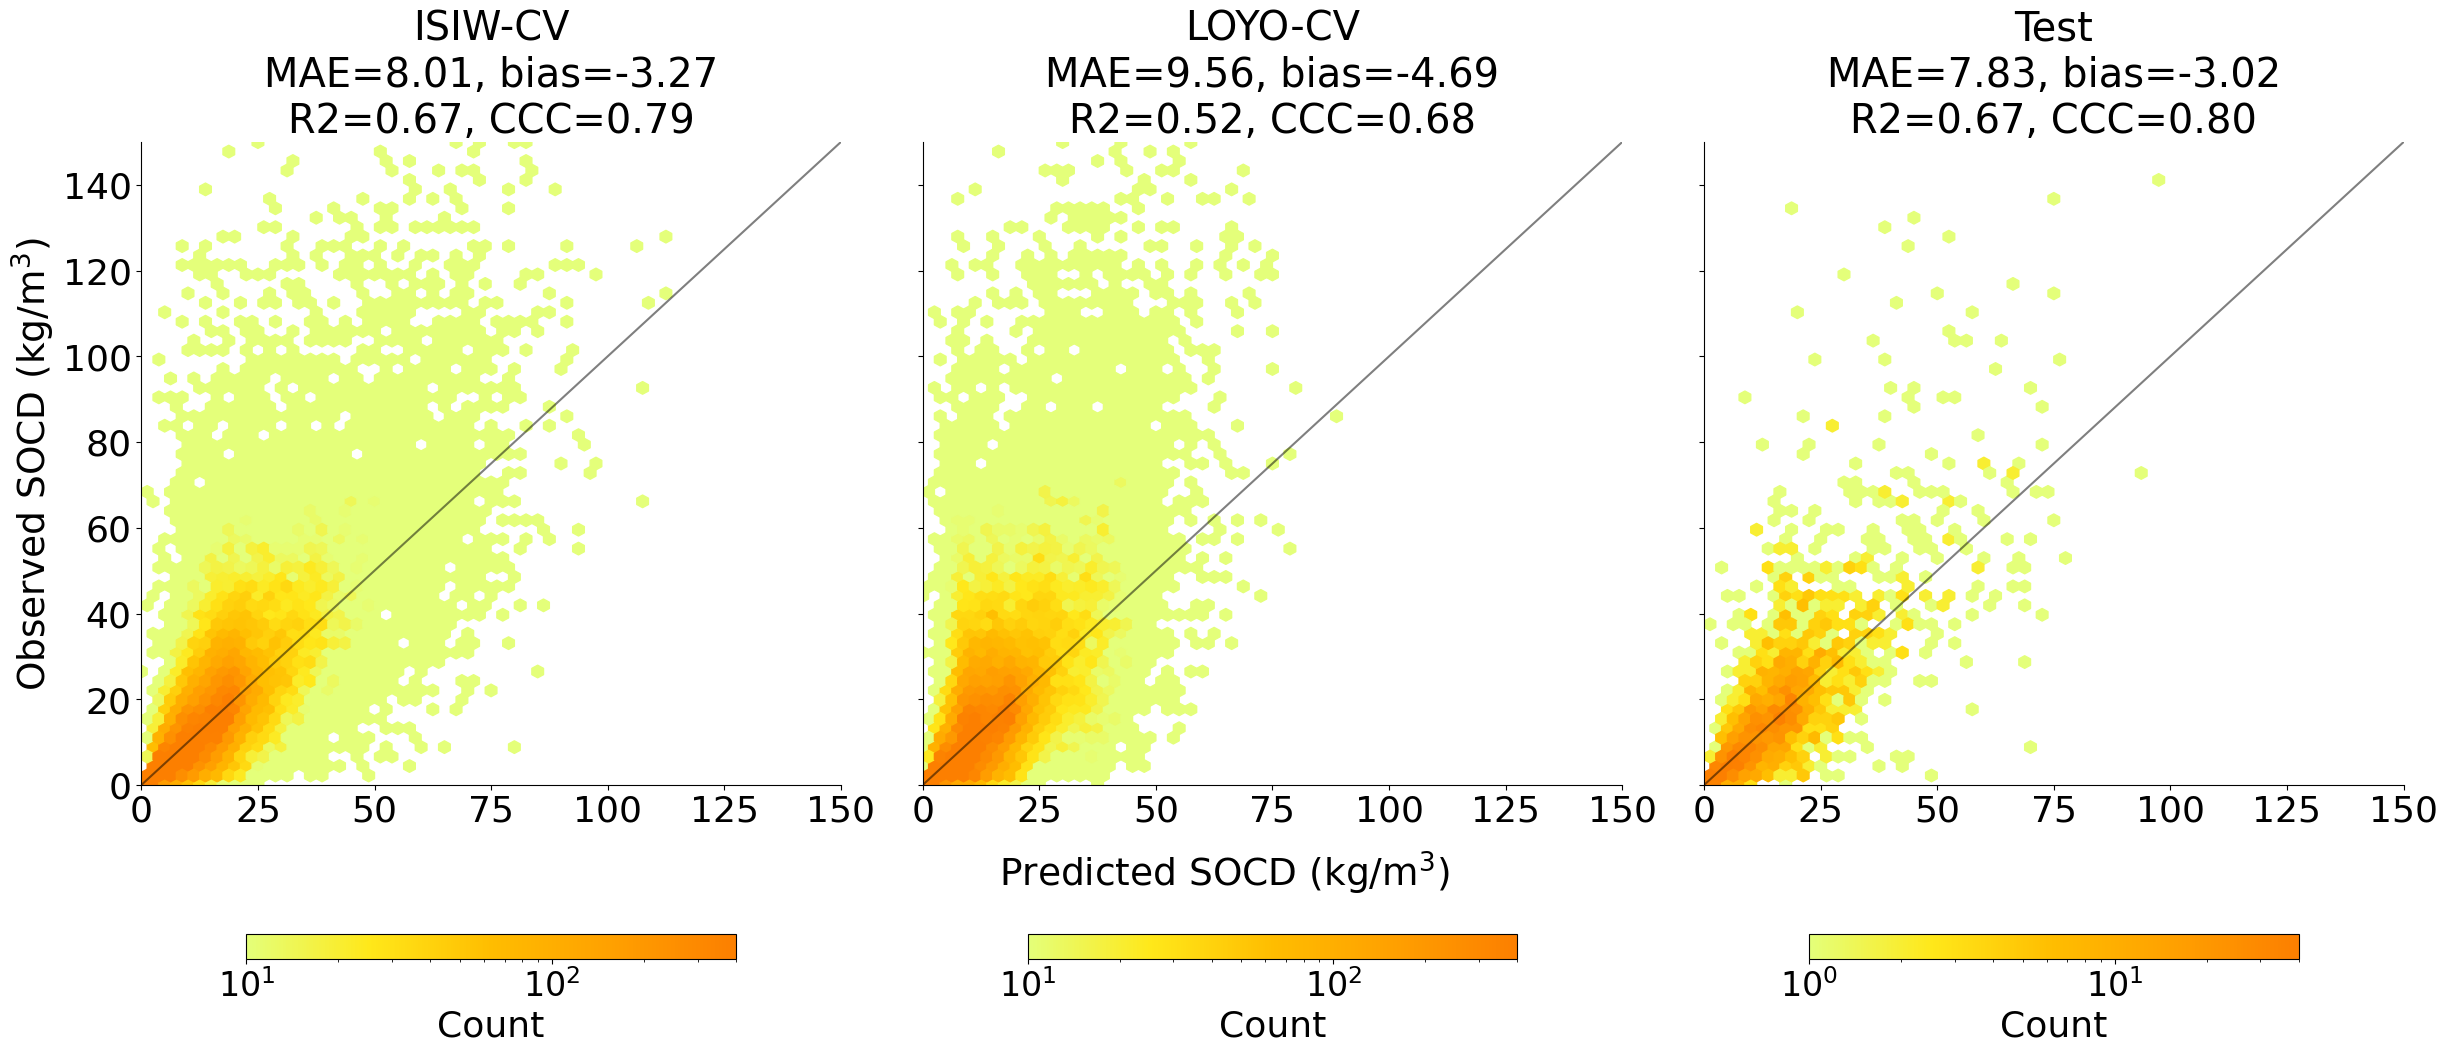

In [24]:
import matplotlib.pyplot as plt
show_low = 0
show_high = 150

x_min, x_max = 0, 150
y_min, y_max = 0, 150

fig, axs = plt.subplots(1, 3, figsize=(25, 11), sharey=True)
# plt.subplots_adjust(wspace=0.01) 
plt.rcParams.update({'font.size': 24})

plot_data = [
    (train[prop], np.expm1(train['isiw_cv']), mae_scv, bias_scv, r2_scv, ccc_scv, 'ISIW-CV', 400, 10),
    (train[prop], np.expm1(train['loy_cv']), mae_tcv, bias_tcv, r2_tcv, ccc_tcv, 'LOYO-CV', 400, 10),
    (test[prop], np.expm1(test['ocd_pred']), mae_test, bias_test, r2_test, ccc_test, 'Test', 40, 1),
]

for ax, (y, x, mae, bias, r2, ccc, title, den_max, den_min) in zip(axs, plot_data):
    # Plot the hexbin
    hb = ax.hexbin(
        x, y, gridsize=60, extent=[x_min, x_max, y_min, y_max],
        cmap='Wistia', mincnt=1, vmin = den_min, vmax=den_max, bins='log'
    )
    # Add diagonal line
    ax.plot([show_low, show_high], [show_low, show_high], "-k", alpha=.5)
    # Set plot title and labels
    ax.set_title(f'{title}\nMAE={mae:.2f}, bias={bias:.2f}\nR2={r2:.2f}, CCC={ccc:.2f}')
    # ax.set_xlabel('Predicted SOCD (kg/m$^3$)')
    if ax == axs[0]:  # Only set ylabel on the first plot
        ax.set_ylabel('Observed SOCD (kg/m$^3$)', fontsize=27)
    ax.set_xlim([show_low, show_high])
    ax.set_ylim([show_low, show_high])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=26)
    ax.set_aspect('auto', adjustable='box')

    # Add individual colorbars at the bottom
    cbar = fig.colorbar(hb, ax=ax, orientation='horizontal', fraction=0.046, pad=0.18, shrink=0.7)
    cbar.set_label('Count',fontsize=26)
    # ticks = [10, 100, 200]
    # cbar.set_ticks(ticks)  # Convert ticks to log scale
    # cbar.set_ticklabels([str(tick) for tick in ticks])  # Set custom tick labels

fig.text(0.5, 0.17, 'Predicted SOCD (kg/m$^3$)', ha='center', fontsize=27)
plt.tight_layout()
plt.savefig(f'{folder_path}/figure/figure_prediction_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()


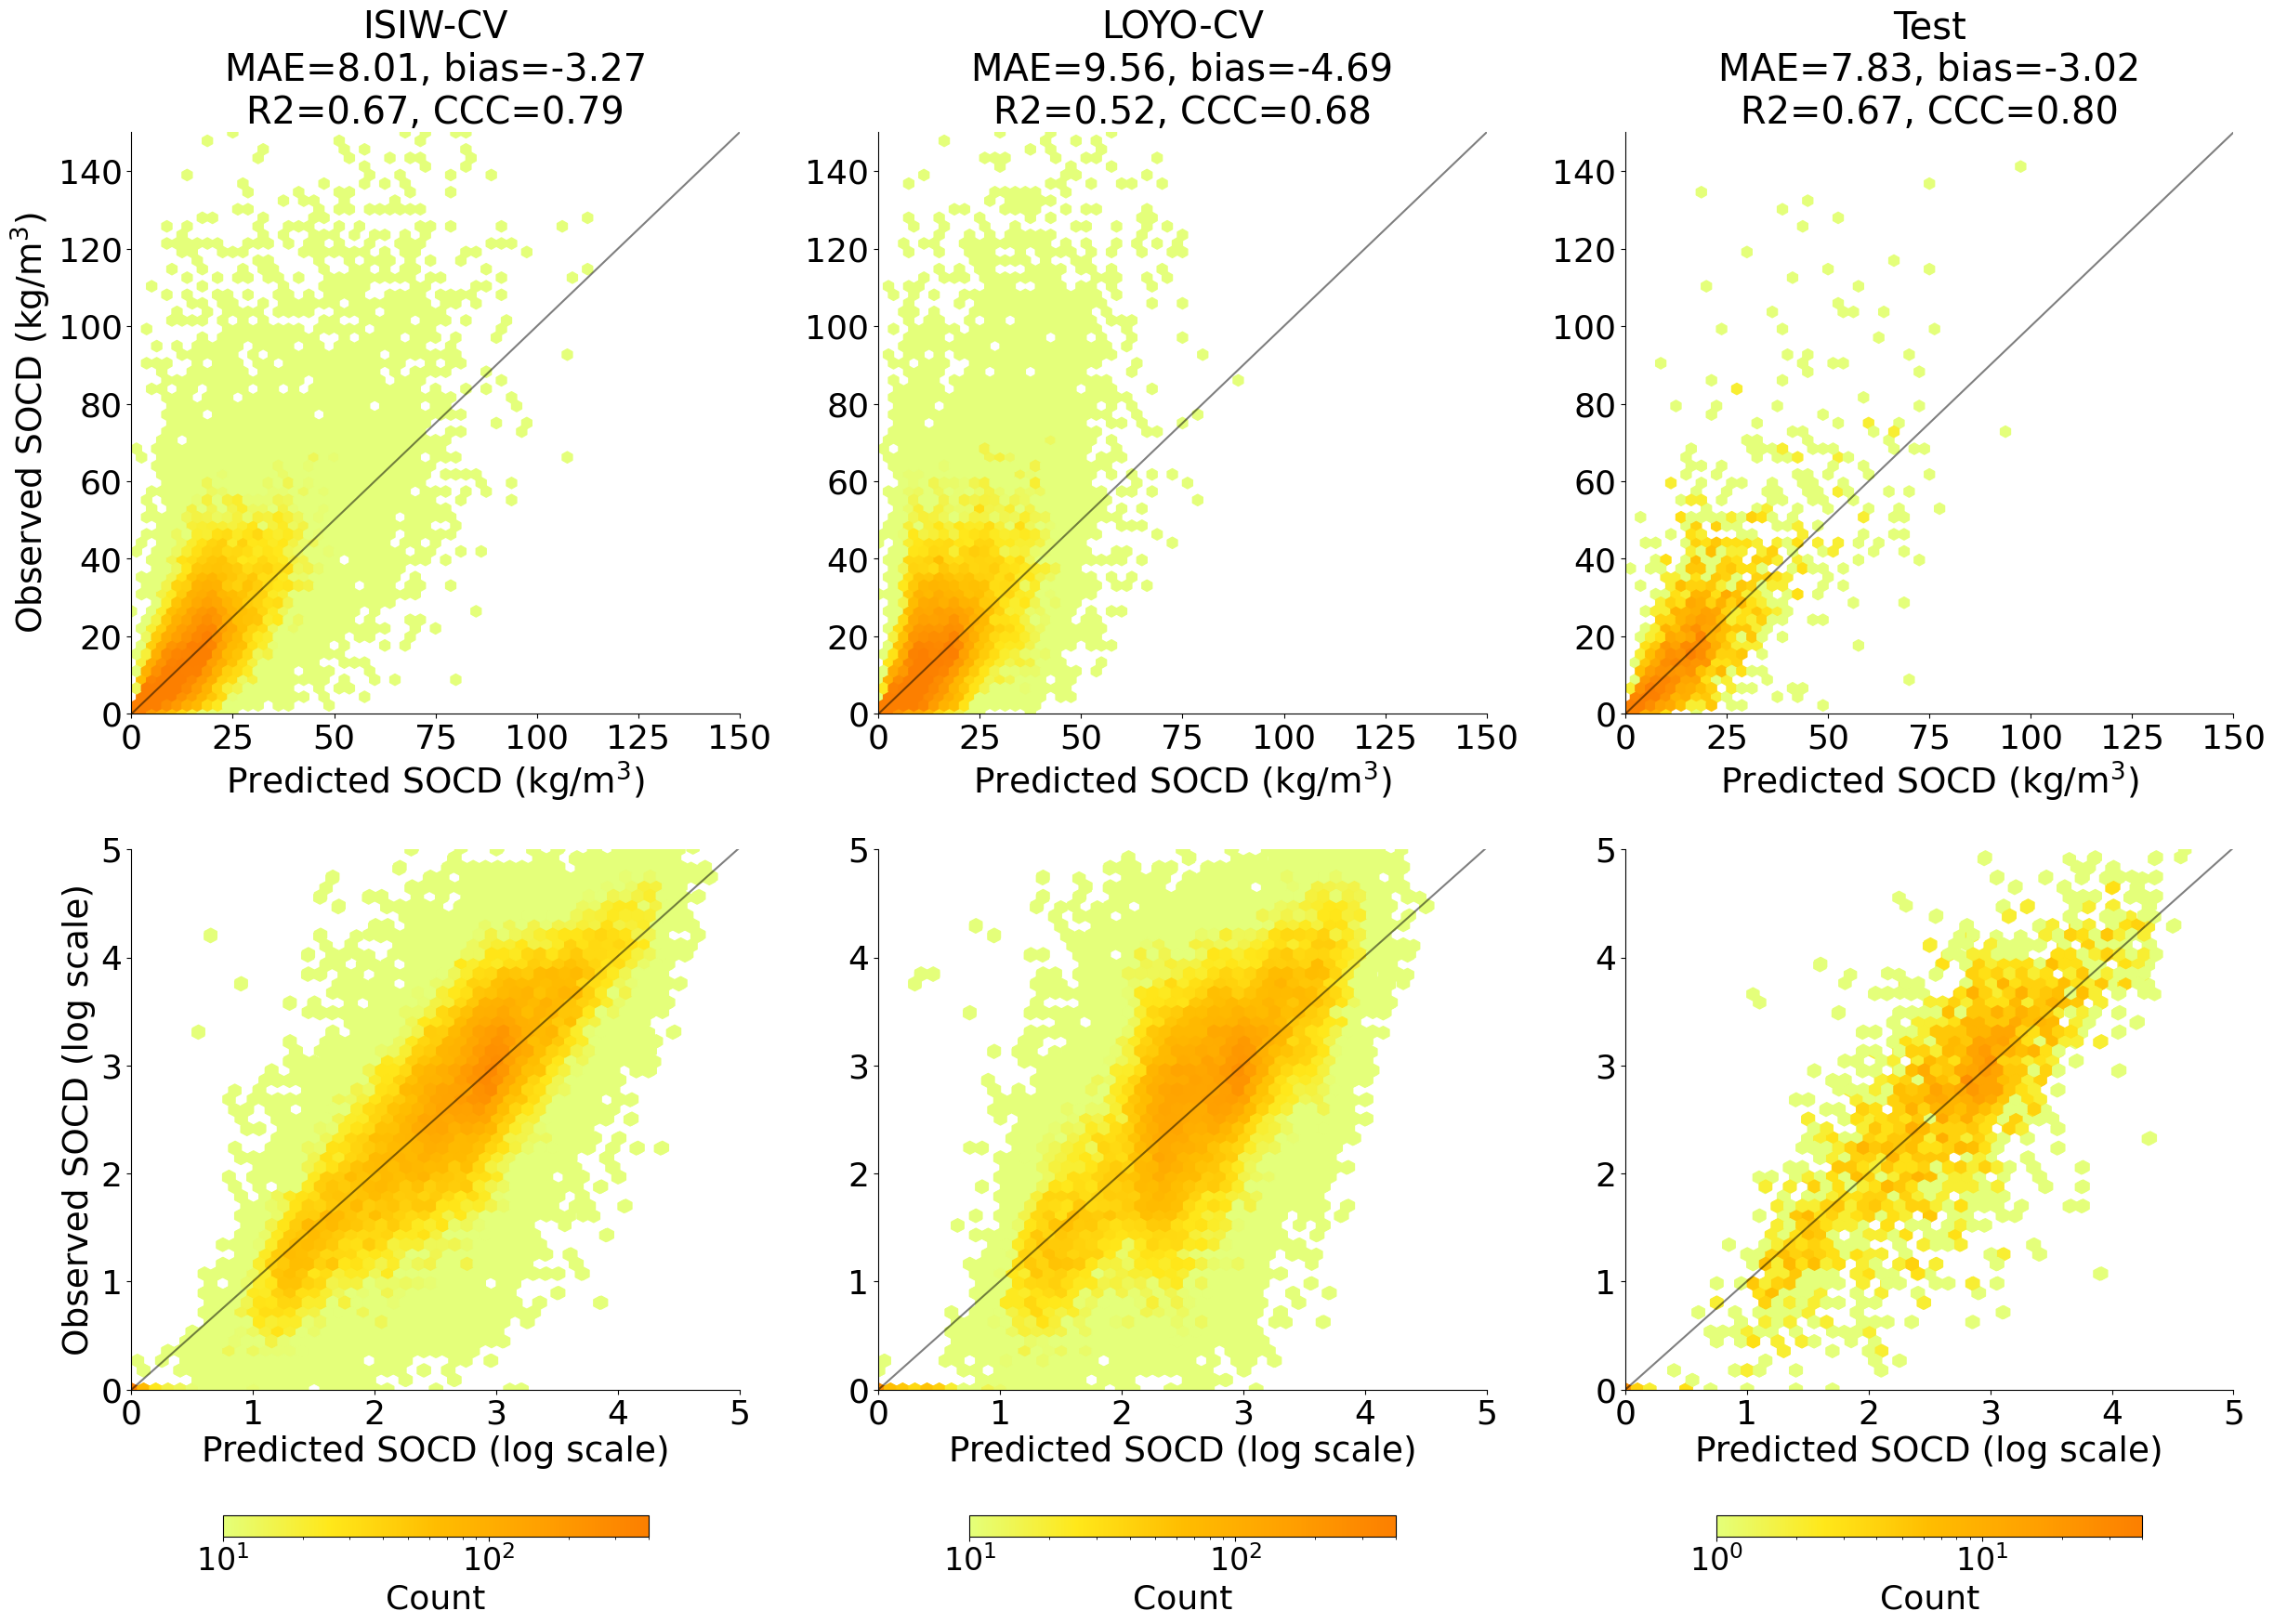

In [72]:
import matplotlib.pyplot as plt
import numpy as np

show_low = 0
show_high = 150


# Adjusted figure dimensions to give more height to the bottom row
fig, axs = plt.subplots(2, 3, figsize=(25, 18), gridspec_kw={'height_ratios': [1, 1.2]})
plt.rcParams.update({'font.size': 24})

plot_data = [
    (train[prop], np.expm1(train['isiw_cv']), mae_scv, bias_scv, r2_scv, ccc_scv, 'ISIW-CV', 400, 10),
    (train[prop], np.expm1(train['loy_cv']), mae_tcv, bias_tcv, r2_tcv, ccc_tcv, 'LOYO-CV', 400, 10),
    (test[prop], np.expm1(test['ocd_pred']), mae_test, bias_test, r2_test, ccc_test, 'Test', 40, 1),
]

# Plot non-log-transformed data (top row)
for i, (y, x, mae, bias, r2, ccc, title, den_max, den_min) in enumerate(plot_data):
    ax = axs[0, i]

    # Plot the hexbin
    hb = ax.hexbin(
        x, y, gridsize=60, extent=[show_low, show_high, show_low, show_high],
        cmap='Wistia', mincnt=1, vmin=den_min, vmax=den_max, bins='log'
    )

    # Add diagonal line
    ax.plot([show_low, show_high], [show_low, show_high], "-k", alpha=.5)

    # Set title and labels
    ax.set_title(f'{title}\nMAE={mae:.2f}, bias={bias:.2f}\nR2={r2:.2f}, CCC={ccc:.2f}')
    if i == 0:
        ax.set_ylabel('Observed SOCD (kg/m$^3$)', fontsize=27)

    ax.set_xlim([show_low, show_high])
    ax.set_ylim([show_low, show_high])
    ax.set_xlabel('Predicted SOCD (kg/m$^3$)', fontsize=27)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=26)
    ax.set_aspect('auto', adjustable='box')

show_high = 5
# Plot log-transformed data (bottom row)
for i, (y, x, mae, bias, r2, ccc, title, den_max, den_min) in enumerate(plot_data):
    ax = axs[1, i]

    # Apply log1p transformation
    y_transformed = np.log1p(y)
    x_transformed = np.log1p(x)

    # Plot the hexbin
    hb = ax.hexbin(
        x_transformed, y_transformed, gridsize=50, extent=[show_low, show_high, show_low, show_high],
        cmap='Wistia', mincnt=1, vmin=den_min, vmax=den_max, bins='log'
    )

    # Add diagonal line
    ax.plot([show_low, show_high], [show_low, np.log1p(150)], "-k", alpha=.5)

    # Set labels
    if i == 0:
        ax.set_ylabel('Observed SOCD (log scale)', fontsize=27)

    ax.set_xlim([show_low, show_high])
    ax.set_ylim([show_low, show_high])
    ax.set_xlabel('Predicted SOCD (log scale)', fontsize=27)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(labelsize=26)
    ax.set_aspect('auto', adjustable='box')

# Add colorbars only for the bottom row
for ax, (y, x, _, _, _, _, _, den_max, den_min) in zip(axs[1], plot_data):
    y_transformed = np.log1p(y)
    x_transformed = np.log1p(x)
    hb = ax.hexbin(
        x_transformed, y_transformed, gridsize=50, extent=[0, np.log1p(150), 0, np.log1p(150)],
        cmap='Wistia', mincnt=1, vmin=den_min, vmax=den_max, bins='log'
    )
    cbar = fig.colorbar(hb, ax=ax, orientation='horizontal', fraction=0.046, pad=0.18, shrink=0.7)
    cbar.set_label('Count', fontsize=26)

plt.tight_layout()
plt.savefig(f'{folder_path}/figure/figure_prediction_accuracy.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()





# Test compare with spatial CV

In [12]:
y_cv = cross_val_predict(model, train[covs], train[tgt], cv=cv, groups=train['tile_id'], n_jobs=60)


In [13]:
mae_cv, medae_cv, mape_cv, ccc_cv, r2_cv, bias_cv = calc_metrics(train[tgt], y_cv, weights=None, space=space)
mae_cv, medae_cv, mape_cv, ccc_cv, r2_cv, bias_cv

(7.994047605370721,
 4.16806257477911,
 inf,
 0.7923614571812119,
 0.6672570375440081,
 -3.2644948221213066)

In [14]:
train.loc[train['weights']<0.5,'ref'].unique()

array(['thuenen.bze.lw', 'ParcelasCOS', 'infosolo', 'GLanCE',
       'ParcelasINES', 'LUCAS'], dtype=object)

In [15]:
len(train)

38348